# Análise de dados sobre Reservas de Hotéis

### Carregar as bibliotecas do Python

In [30]:
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict
from collections import defaultdict
import numpy as np
from scipy import stats
import pandas as pd
from scipy.io import arff
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import learning_curve
#from sklearn.cross_validation import train_test_split
#from sklearn.grid_search import GridSearchCV
#from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
import datetime
import time
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#sns.set_context('notebook') 
sns.set_style(style='darkgrid')

from pprint import pprint 
cmaps = OrderedDict()
import plotly.express as px



ModuleNotFoundError: No module named 'plotly'

### Vamos carregar o arquivo da base de dados hotels.txt

In [2]:
df = pd.read_csv("hotels.txt",delimiter="\t")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342.0,2015.0,July,27.0,1.0,0,0,2.0,...,No Deposit,NaN,NaN,0,Transient,0,0,0,Check-Out,01/07/2015
1,Resort Hotel,0,737.0,2015.0,July,27.0,1.0,0,0,2.0,...,No Deposit,NaN,NaN,0,Transient,0,0,0,Check-Out,01/07/2015
2,Resort Hotel,0,7.0,2015.0,July,27.0,1.0,0,1,1.0,...,No Deposit,NaN,NaN,0,Transient,75,0,0,Check-Out,02/07/2015
3,Resort Hotel,0,13.0,2015.0,July,27.0,1.0,0,1,1.0,...,No Deposit,304.0,NaN,0,Transient,75,0,0,Check-Out,02/07/2015
4,Resort Hotel,0,14.0,2015.0,July,27.0,1.0,0,2,2.0,...,No Deposit,240.0,NaN,0,Transient,98,0,1,Check-Out,03/07/2015


### Visão Geral dos dados

#### Utilizamos a função shape para verificarmos o número de colúnas e a quantidade de observações

In [3]:
print("Total de observações [linhas] x variáveis [colunas]: ", df.shape)


Total de observações [linhas] x variáveis [colunas]:  (17145, 32)


#### Vamos verificar os nomes das variáveis e seu respectivos tipos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17145 entries, 0 to 17144
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           17145 non-null  object 
 1   is_canceled                     17145 non-null  int64  
 2   lead_time                       17144 non-null  float64
 3   arrival_date_year               17141 non-null  float64
 4   arrival_date_month              17137 non-null  object 
 5   arrival_date_week_number        17143 non-null  float64
 6   arrival_date_day_of_month       17144 non-null  float64
 7   stays_in_weekend_nights         17145 non-null  int64  
 8   stays_in_week_nights            17145 non-null  int64  
 9   adults                          17141 non-null  float64
 10  children                        17145 non-null  int64  
 11  babies                          17144 non-null  float64
 12  meal                            

#### Vamos avaliar se há observações duplicadas neste conjunto de dados - (se há linhas duplicadas no Dataframe)

In [5]:
temp_csdata = df.append(df)                             # Fazer uma cópia do DF csdata em DF temporário (temp_csdata) 
                                                                # e duplicar todas as linhas do DF original
temp_csdata . drop_duplicates ( inplace = True , keep = False ) # Eliminar toda a duplicidade do arquivo
temp_csdata . shape                                             # As linhas que restarem deste DF, são as observações 
                                                                # duplicadas do conj. de dados
 

(0, 32)

#### Verificando se existem dados nulos no conjunto de dados 

In [6]:
df.isnull().sum() #/ len(df)

hotel                                 0
is_canceled                           0
lead_time                             1
arrival_date_year                     4
arrival_date_month                    8
arrival_date_week_number              2
arrival_date_day_of_month             1
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                4
children                              0
babies                                1
meal                                  0
country                               3
market_segment                        1
distribution_channel                  3
is_repeated_guest                     1
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    1
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              2273
company                           16196


### Limpeza dos dados
### Com base nas informações da documentação, vamos utilizar técnicas para tratar os dados que estão faltando

#### Como não é possível deduzirmos/inferirmos valores para as colunas 'reservation_status', 'reserved_room_type' e 'is_repeated_guest' sem utilização de machine learning, e por serem pouquíssimos registros nessas situações (4 no total), vamos remover os registros nulos do DataFrame

In [7]:
df = df[df['reservation_status'].notna()]
df = df[df['reserved_room_type'].notna()]
df = df[df['is_repeated_guest'].notna()]

#### Para a variável "lead_time", vamos utilizar o valor médio para preencher as células nulas
#### Para as colunas adults e babies nulas, vamos considerar o valor 0
#### Para a variável 'agent' nula, vamos considerar que não foi utilizada nenhum agente na reserva (=0)
#### Para a variável 'company' nula, vamos considerar que a reserva tenha sido feita de forma privada (=0)
#### Para as variaveis 'market_segment' e 'distribution_channel' nulas, vamos considerar que a reserva foi feita de forma direta (categoria 'Direct')
#### Para a variável 'country' nula, vamos considerar o país 'Unknown'

In [8]:
lead_time_medio = round(df['lead_time'].mean())

nan_replacements = {"lead_time": lead_time_medio,"adults": 0, "babies": 0, "agent": 0, "company": 0, "country": "Unknown", 'market_segment': 'Direct', 'distribution_channel': 'Direct'}

full_data_cln = df.fillna(nan_replacements)
full_data_cln.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 2
arrival_date_month                7
arrival_date_week_number          2
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

#### Vamos calcular a variável arrival_date_year com base na reservation_status_date  menos a quantidade total de estadias

In [9]:
#Vamos definir uma função que calcula o arrival_date_year de acordo com o reservation_status_date
def getYearFromDate(p_date,p_weekend,p_week):
    dt = datetime.datetime.strptime(p_date, '%d/%m/%Y')
    estadia = p_weekend + p_week
    dataChegada = dt - datetime.timedelta(days=estadia)
    ano = dataChegada.year
    return ano

#Vamos aplicar a função em todos os registros que estão com arrival_date_year nulo
full_data_cln['arrival_date_year'] = full_data_cln.apply(
    lambda x: getYearFromDate(x['reservation_status_date'],x['stays_in_weekend_nights'],x['stays_in_week_nights']) if pd.isnull(x['arrival_date_year'])  and x['reservation_status']=='Check-Out' else x['arrival_date_year'],
    axis=1
)
#Vamos verificar os valores nulos
full_data_cln.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                7
arrival_date_week_number          2
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

#### Vamos calcular o arrival_date_month faltante com base no reservation_status_date menos a quantidade total de estadias

In [10]:
# Vamos definir uma função para calcular o arrival_date_month com base no reservation_status_date - a quantidade total de estadias
def getMonthFromReservationDate(p_date,p_weekend,p_week):
    dt = datetime.datetime.strptime(p_date, '%d/%m/%Y')
    estadia = p_weekend + p_week
    dataChegada = dt - datetime.timedelta(days=estadia)
    mes = dataChegada.strftime("%B")
    return mes



#Vamos aplicar a função em todos os registros que estão com arrival_date_month nulo
full_data_cln['arrival_date_month'] = full_data_cln.apply(
    lambda x: getMonthFromReservationDate(x['reservation_status_date'],x['stays_in_weekend_nights'],x['stays_in_week_nights']) if pd.isnull(x['arrival_date_month']) and x['reservation_status']=='Check-Out' else x['arrival_date_month'],
    axis=1
)

#Vamos verificar os valores nulos
full_data_cln.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          2
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

#### Aqui calculamos a arrival_date_week_number com base nas variaveis arrival_date_day_of_month, arrival_date_month, arrival_date_year

In [11]:
#Vamos definir uma função que retorna a moda da semana para o ano/mês
def getWeekNumberFromDate(p_year,p_month,p_day):
    dateStr= str(int(p_year))+'-'+p_month+'-'+str(int(p_day))
    datetime_object = datetime.datetime.strptime(dateStr, '%Y-%B-%d')
    
    week = datetime_object.isocalendar()[1]
    return week


#Aplicamos a função no dataframe
full_data_cln['arrival_date_week_number'] = full_data_cln.apply(
    lambda x: getWeekNumberFromDate(x['arrival_date_year'],x['arrival_date_month'],x['arrival_date_day_of_month']) if pd.isnull(x['arrival_date_week_number']) else x['arrival_date_week_number'],
    axis=1
)

#Vamos verificar os valores nulos
full_data_cln.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

### Transformação dos dados

#### Vamos converter a coluna reservation_status_date de Object (data em formato string) para seu timestamp int "reservation_status_timestamp" (métrico)
#### Vamos transformar as variáveis categóricas (datatype = objetc) em categorias usando o data frame auxiliar (df_cat).
#### Vamos criar um outro data frame auxiliar (df_num), onde teremos apenas as variáveis contínuas.

In [12]:
#Vamos converter a coluna reservation_status_date de Object (Data em formato string) para seu timestamp int "reservation_status_timestamp"
df_backup = df.copy()
df['reservation_status_timestamp'] = pd.to_datetime(df['reservation_status_date'], format="%d/%m/%Y")
df['reservation_status_timestamp'] = df.reservation_status_timestamp.astype('int64') // 10**9
del df['reservation_status_date']

#df.info()
#df.head()

# Transformar as variáveis categóricas em categorias
df_cat = df.copy()
numcols = df_cat.select_dtypes(include ='object').columns
df_cat[numcols] = df_cat[numcols].astype('category')

# Criar um data frame auxiliar com apenas as variáveis numéricas
df_num = df.copy()
df_cat2 = df_cat.copy()
df_num = df_num.select_dtypes(include = 'int64')
df_float = df.select_dtypes(include = 'float64')
df_cat2 = df_cat2.select_dtypes(include = 'category')



df_num= df_num.join(df_float)

df_cat.info()
df_num.info()
df_cat2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17141 entries, 0 to 17144
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   hotel                           17141 non-null  category
 1   is_canceled                     17141 non-null  int64   
 2   lead_time                       17140 non-null  float64 
 3   arrival_date_year               17139 non-null  float64 
 4   arrival_date_month              17134 non-null  category
 5   arrival_date_week_number        17139 non-null  float64 
 6   arrival_date_day_of_month       17141 non-null  float64 
 7   stays_in_weekend_nights         17141 non-null  int64   
 8   stays_in_week_nights            17141 non-null  int64   
 9   adults                          17137 non-null  float64 
 10  children                        17141 non-null  int64   
 11  babies                          17140 non-null  float64 
 12  meal              

#### Vamos agora visualizar as estruturas de dados das variáveis métricas e das variáveis categóricas.

In [13]:
print()
print('Visualização inicial da Estrutura dos Dados (Reserva de Hotel) ')
print()
print(' Variáveis Métricas -- Quant. Vals. Distintos --- ')
print()
print(df_num.nunique(axis=0))
print()
print(' Variáveis Categóricas -- Níveis --- ')
print()
print(df_cat2.nunique(axis=0))
print()



Visualização inicial da Estrutura dos Dados (Reserva de Hotel) 

 Variáveis Métricas -- Quant. Vals. Distintos --- 

is_canceled                          2
stays_in_weekend_nights             13
stays_in_week_nights                27
children                             5
previous_cancellations               5
previous_bookings_not_canceled      22
booking_changes                     14
days_in_waiting_list                27
adr                               3173
required_car_parking_spaces          4
total_of_special_requests            6
reservation_status_timestamp       719
lead_time                          364
arrival_date_year                    3
arrival_date_week_number            53
arrival_date_day_of_month           31
adults                              14
babies                               3
is_repeated_guest                    2
agent                              166
company                            112
dtype: int64

 Variáveis Categóricas -- Níveis --- 

hotel     

### Analise dos dados

#### Estatísticas Descritivas das variáveis numéricas

In [14]:
pd.set_option('float_format', '{:.2f}'.format)
df_num.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
is_canceled,17141.00,0.22,0.41,0.00,0.00,0.00,0.00,1.00
stays_in_weekend_nights,17141.00,1.00,1.02,0.00,0.00,1.00,2.00,16.00
stays_in_week_nights,17141.00,2.65,2.03,0.00,1.00,2.00,4.00,41.00
children,17141.00,0.12,0.42,0.00,0.00,0.00,0.00,10.00
previous_cancellations,17141.00,0.01,0.13,0.00,0.00,0.00,0.00,5.00
previous_bookings_not_canceled,17141.00,0.05,0.67,0.00,0.00,0.00,0.00,21.00
booking_changes,17141.00,0.26,0.68,0.00,0.00,0.00,0.00,17.00
days_in_waiting_list,17141.00,1.46,13.12,0.00,0.00,0.00,0.00,178.00
adr,17141.00,2755.71,4611.90,0.00,89.00,248.00,1835.00,34963.00
required_car_parking_spaces,17141.00,0.06,0.24,0.00,0.00,0.00,0.00,3.00


#### Estatísticas Descritivas das variáveis categóricas

In [15]:
df_cat2.describe().transpose()

,count,unique,top,freq
hotel,17141,2,City Hotel,10106
arrival_date_month,17134,12,October,2953
meal,17141,5,BB,12510
country,17138,108,PRT,6041
market_segment,17140,7,Online TA,8936
distribution_channel,17138,4,TA/TO,13770
reserved_room_type,17141,10,A,12000
assigned_room_type,17141,11,A,10179
deposit_type,17141,3,No Deposit,16321
customer_type,17141,4,Transient,13178


#### Assimetria - Skew 

In [16]:
df_cat.skew()

is_canceled                       1.37
lead_time                         1.18
arrival_date_year                -0.58
arrival_date_week_number         -0.94
arrival_date_day_of_month         0.05
stays_in_weekend_nights           1.43
stays_in_week_nights              2.72
adults                           29.57
children                          4.31
babies                           10.07
is_repeated_guest                 7.52
previous_cancellations           29.97
previous_bookings_not_canceled   19.72
booking_changes                   5.02
agent                             0.61
company                          -0.10
days_in_waiting_list             10.37
adr                               1.91
required_car_parking_spaces       3.75
total_of_special_requests         0.96
reservation_status_timestamp     -0.67
dtype: float64

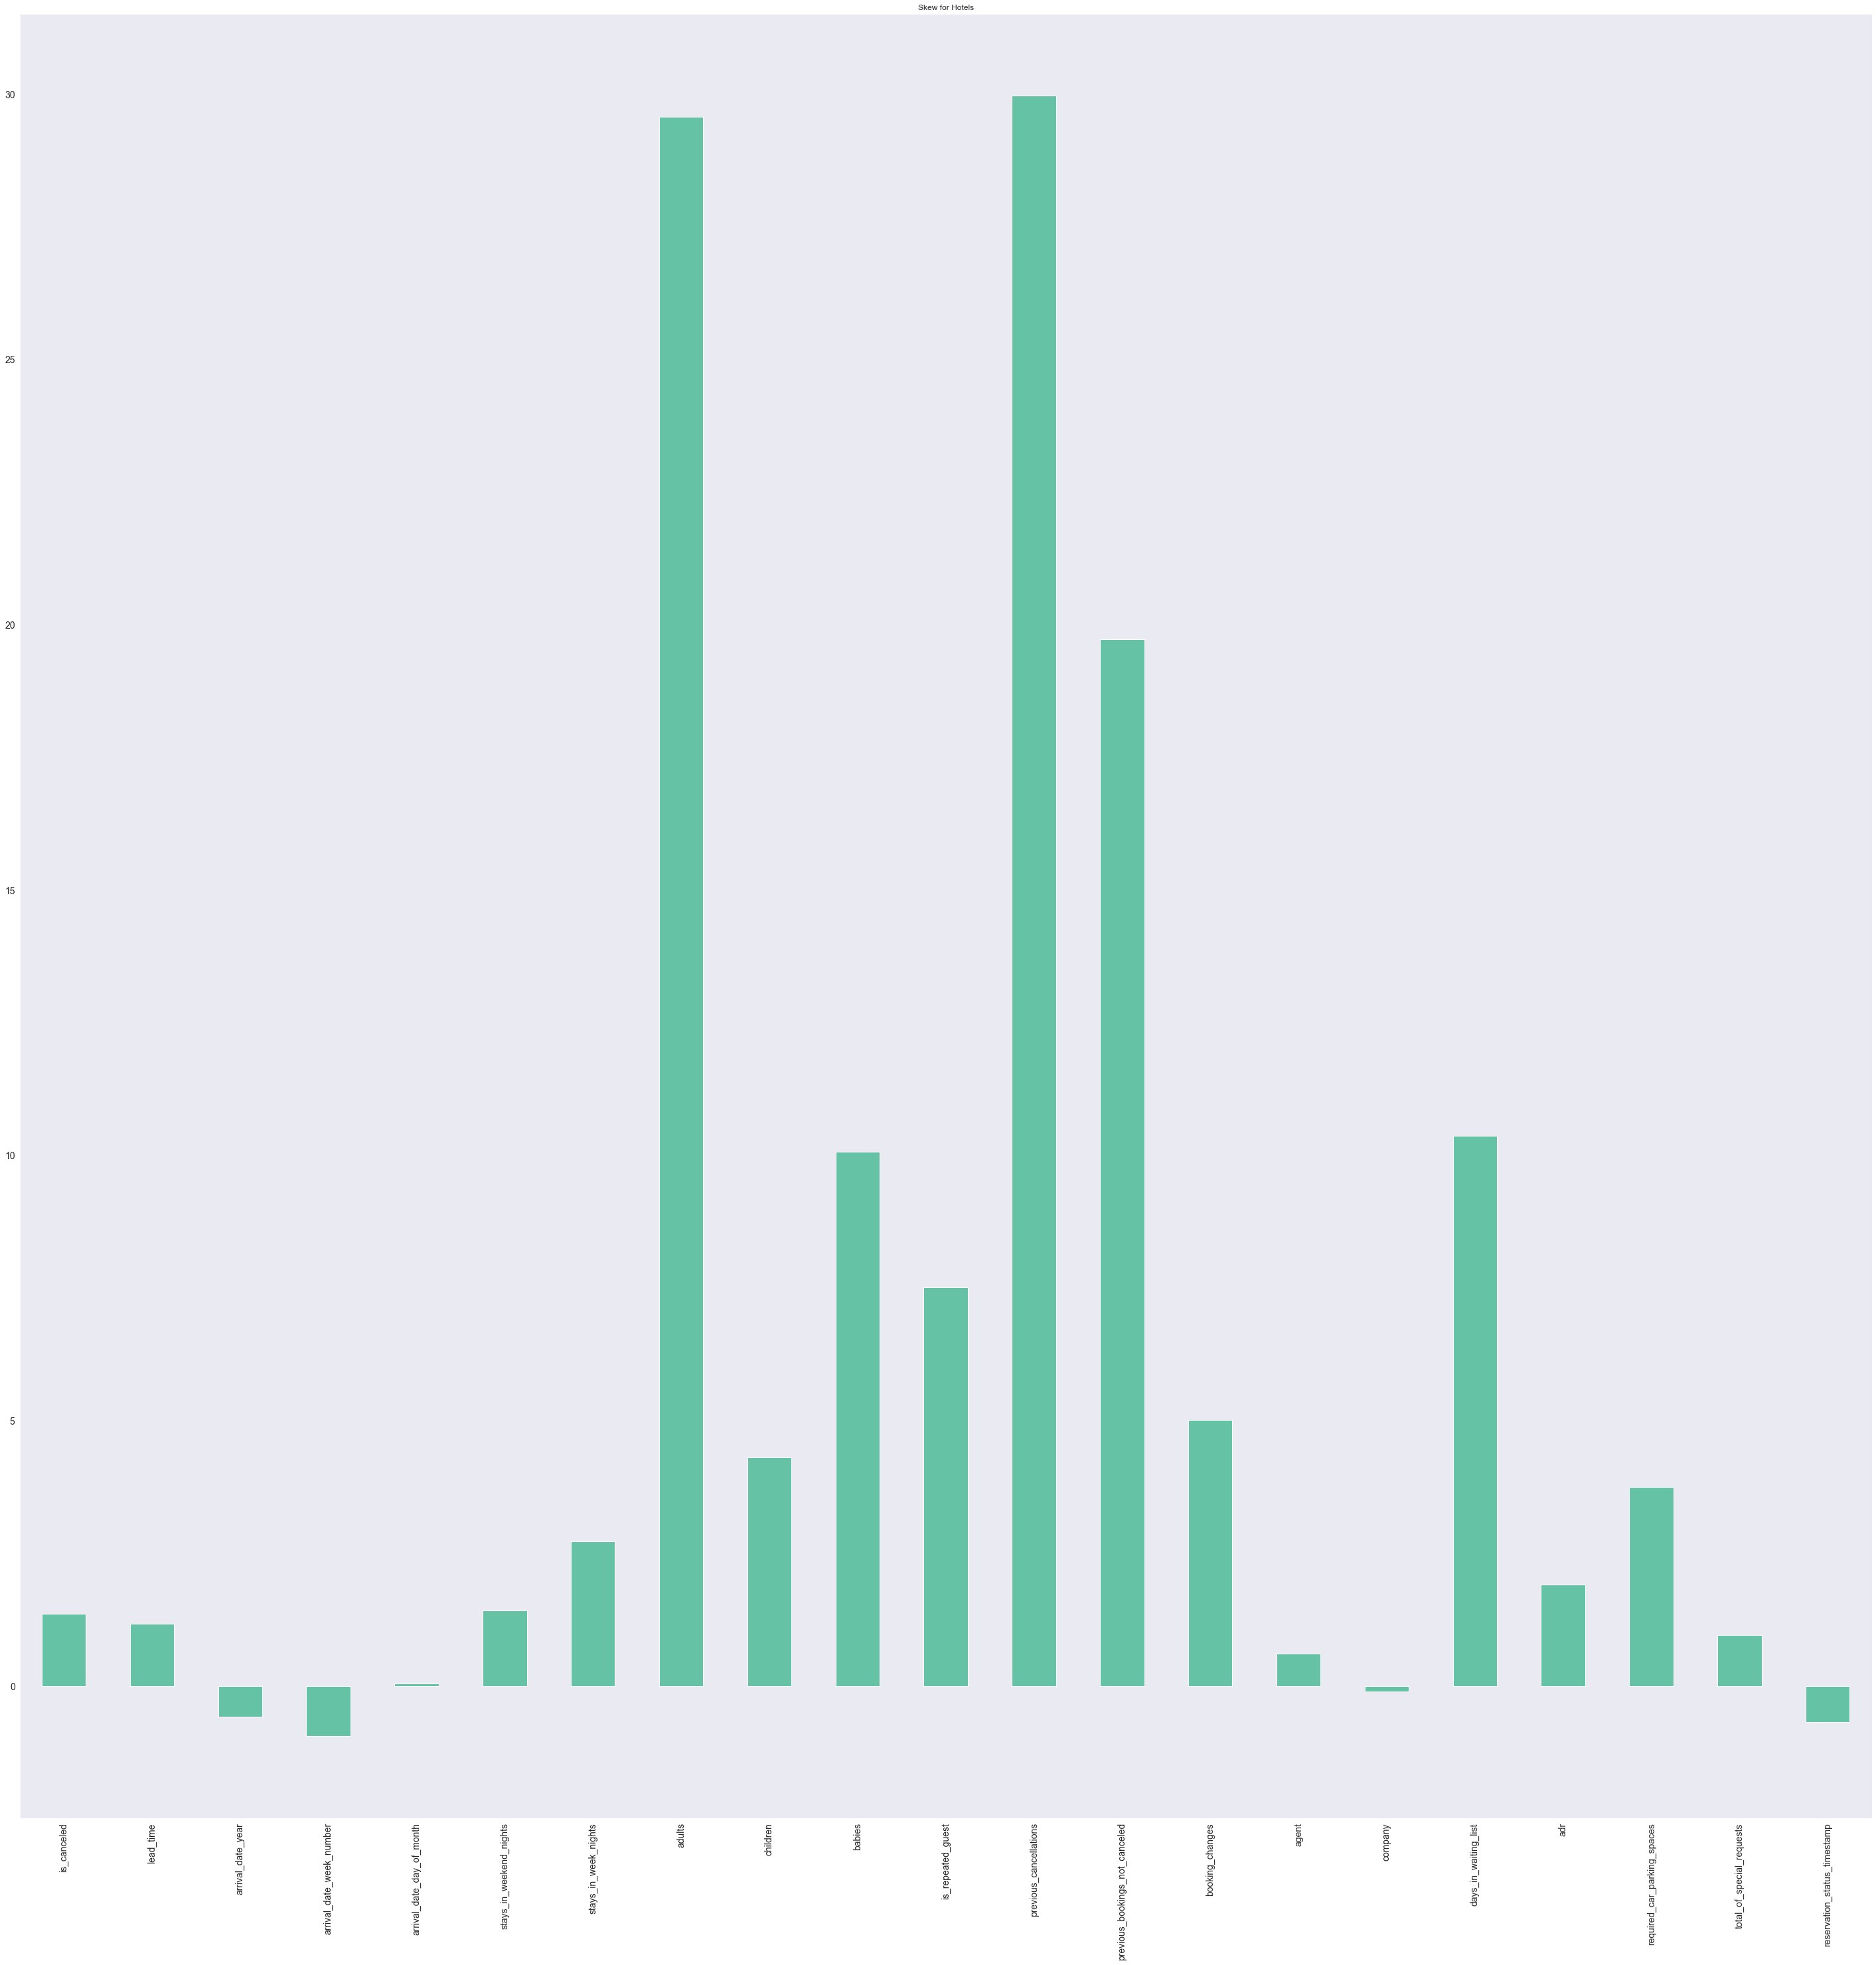

In [17]:
sk = df_cat.skew().plot.bar(colormap = 'Set2', grid = False, fontsize = 14, figsize = (50,50), title = "Skew for Hotels")

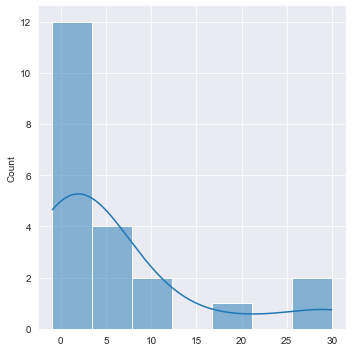

In [18]:
#Outra visualização do Skew
sns.displot(df_cat.skew(),  kde=True)

#### Kurtosis

In [19]:
df_cat.kurtosis()

is_canceled                        -0.14
lead_time                           1.02
arrival_date_year                   0.45
arrival_date_week_number            0.29
arrival_date_day_of_month          -1.22
stays_in_weekend_nights             7.80
stays_in_week_nights               22.51
adults                           1350.40
children                           29.58
babies                            108.21
is_repeated_guest                  54.55
previous_cancellations            979.73
previous_bookings_not_canceled    455.39
booking_changes                    55.30
agent                              -1.30
company                            -0.92
days_in_waiting_list              114.60
adr                                 3.11
required_car_parking_spaces        12.87
total_of_special_requests           0.43
reservation_status_timestamp       -0.80
dtype: float64

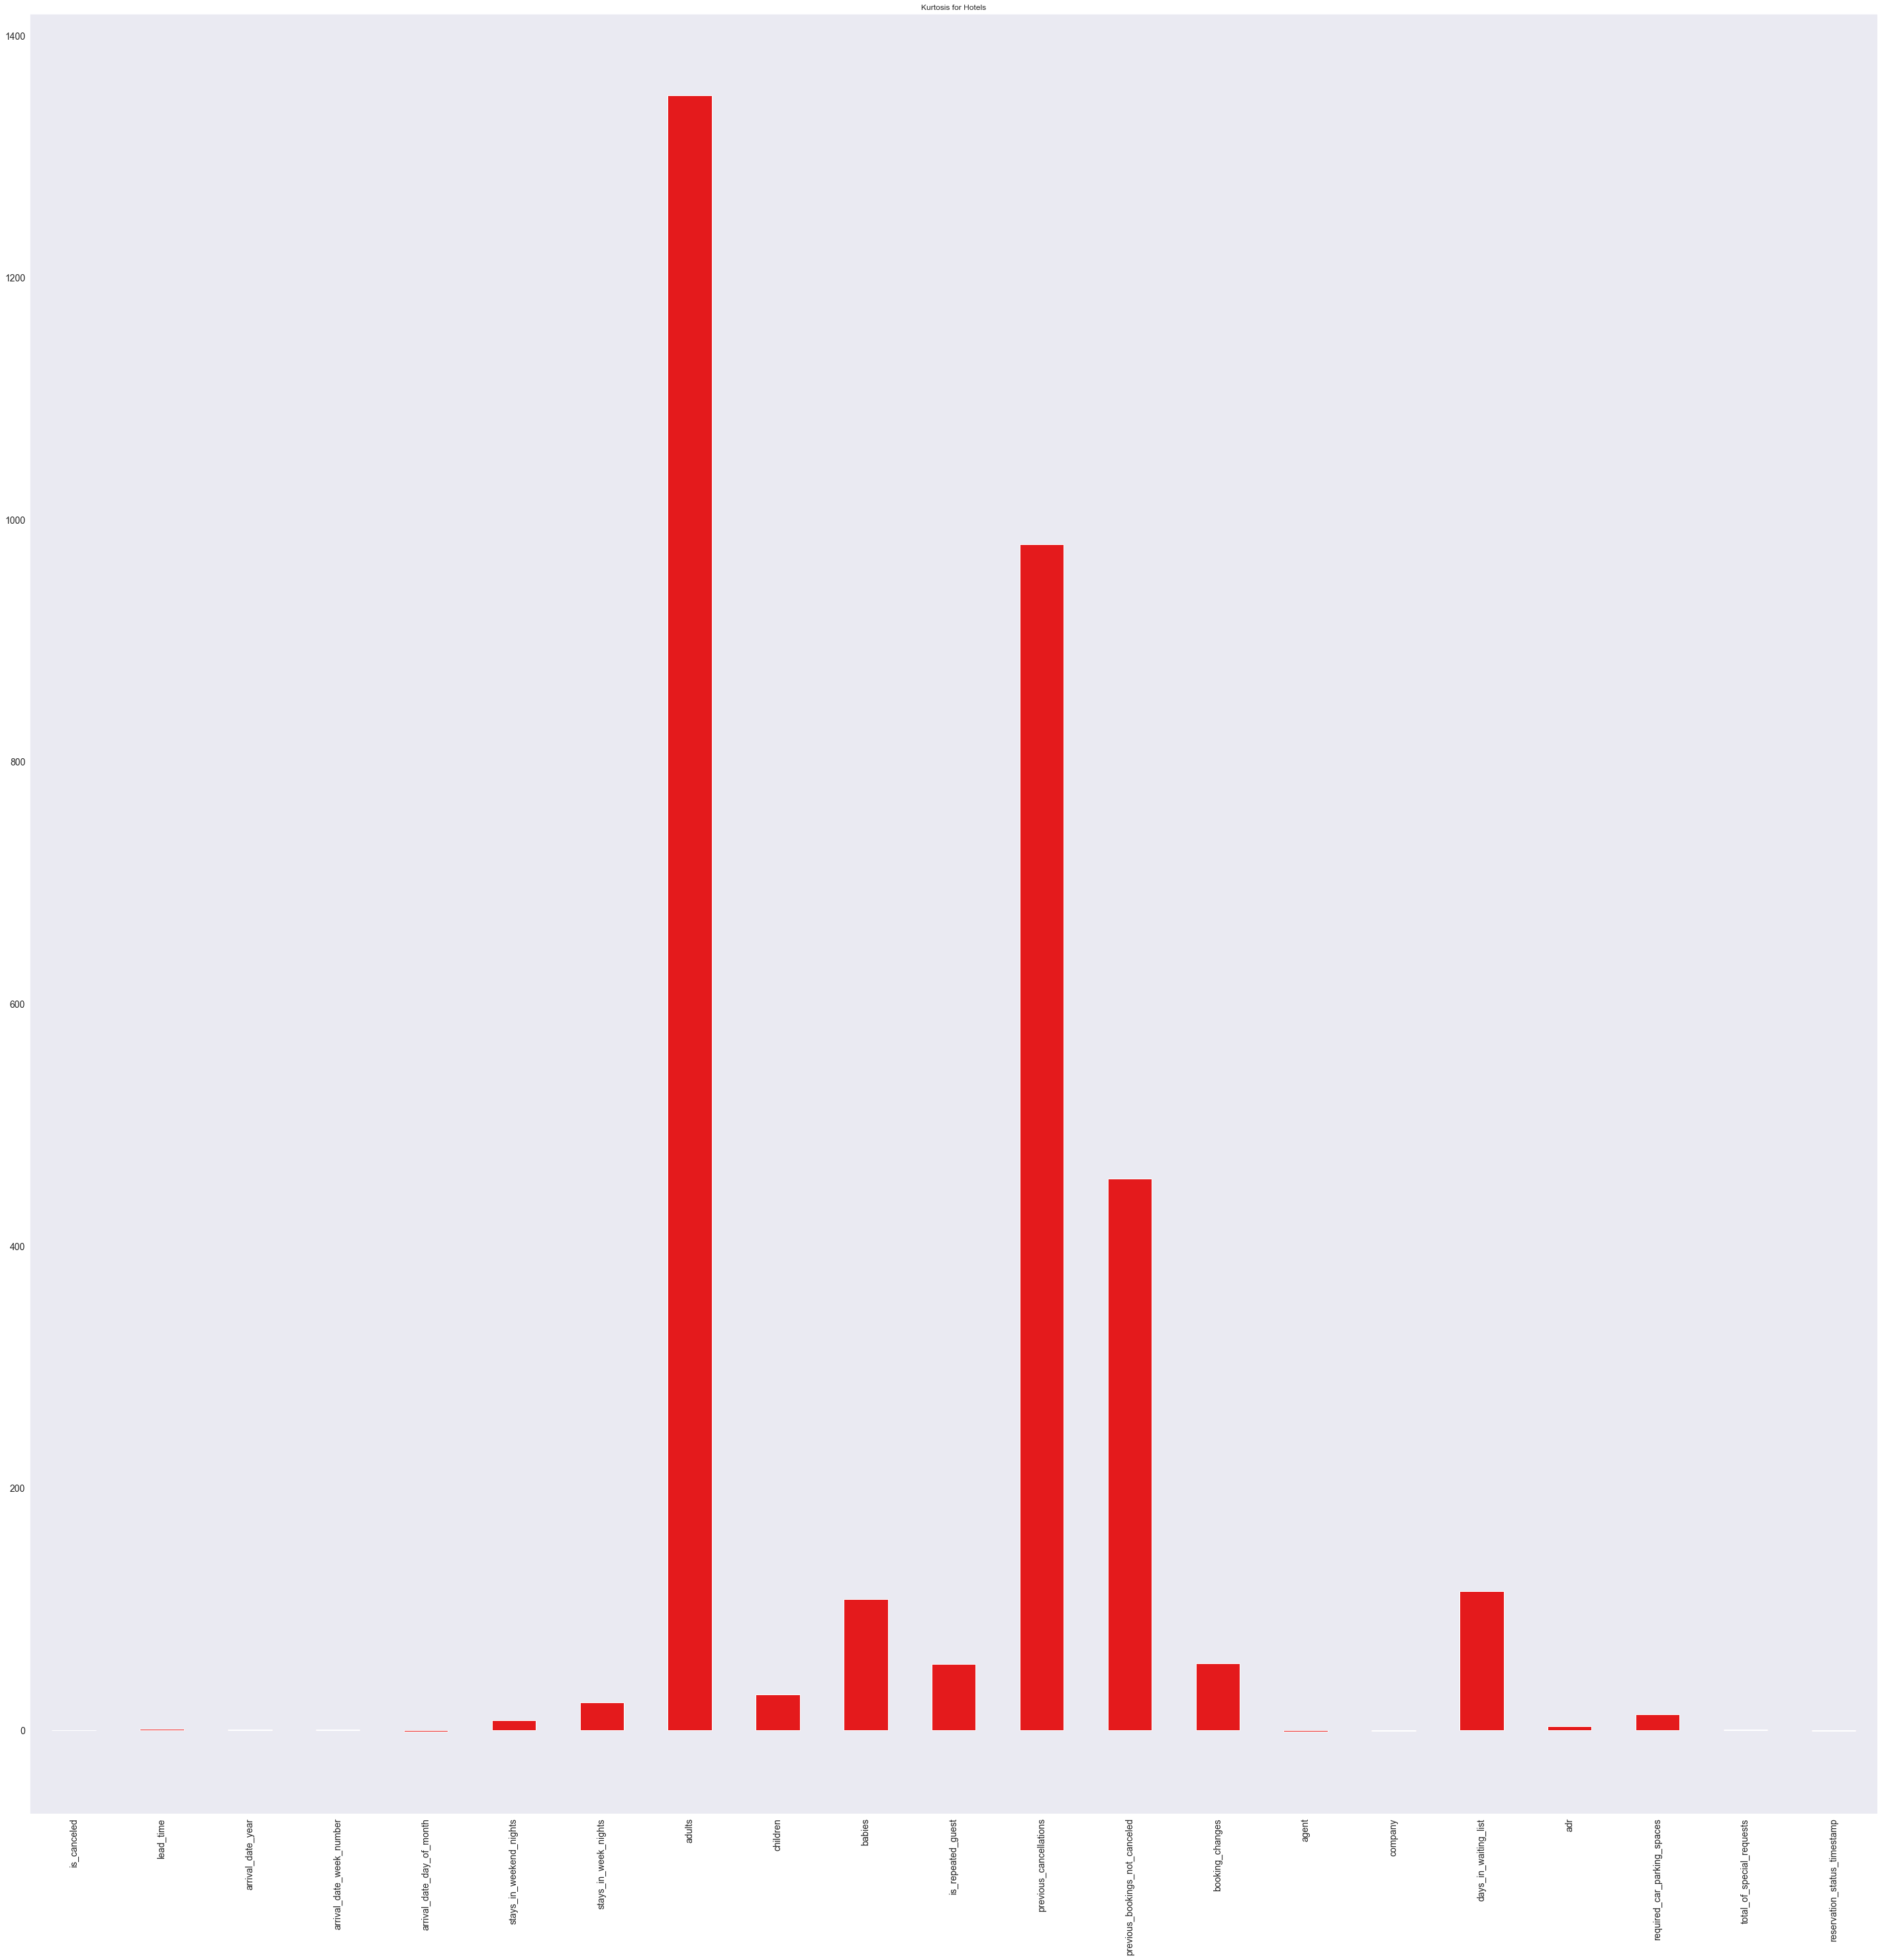

In [20]:
kur = df_cat.kurtosis().plot.bar(colormap = 'Set1', grid = False, fontsize = 14, figsize = (50,50), title = "Kurtosis for Hotels")

#### Análise - Análise Univariada da Variável Dependente ou Resposta - is_canceled

   counts  per per100
0   13402 0.78  78.2%
1    3739 0.22  21.8%


<AxesSubplot:xlabel='is_canceled', ylabel='count'>

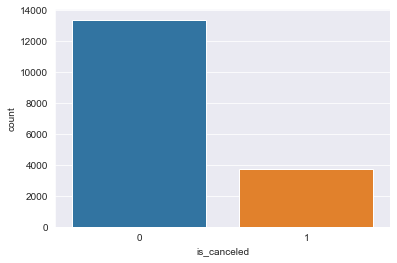

In [21]:
counts = df_cat.is_canceled.value_counts()
percent = df_cat.is_canceled.value_counts(normalize=True)
percent100 = df_cat.is_canceled.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print(pd.DataFrame({'counts' : counts, 'per': percent, 'per100': percent100}))


sns.countplot(x='is_canceled', data=df_cat)

#### Heatmap

<AxesSubplot:>

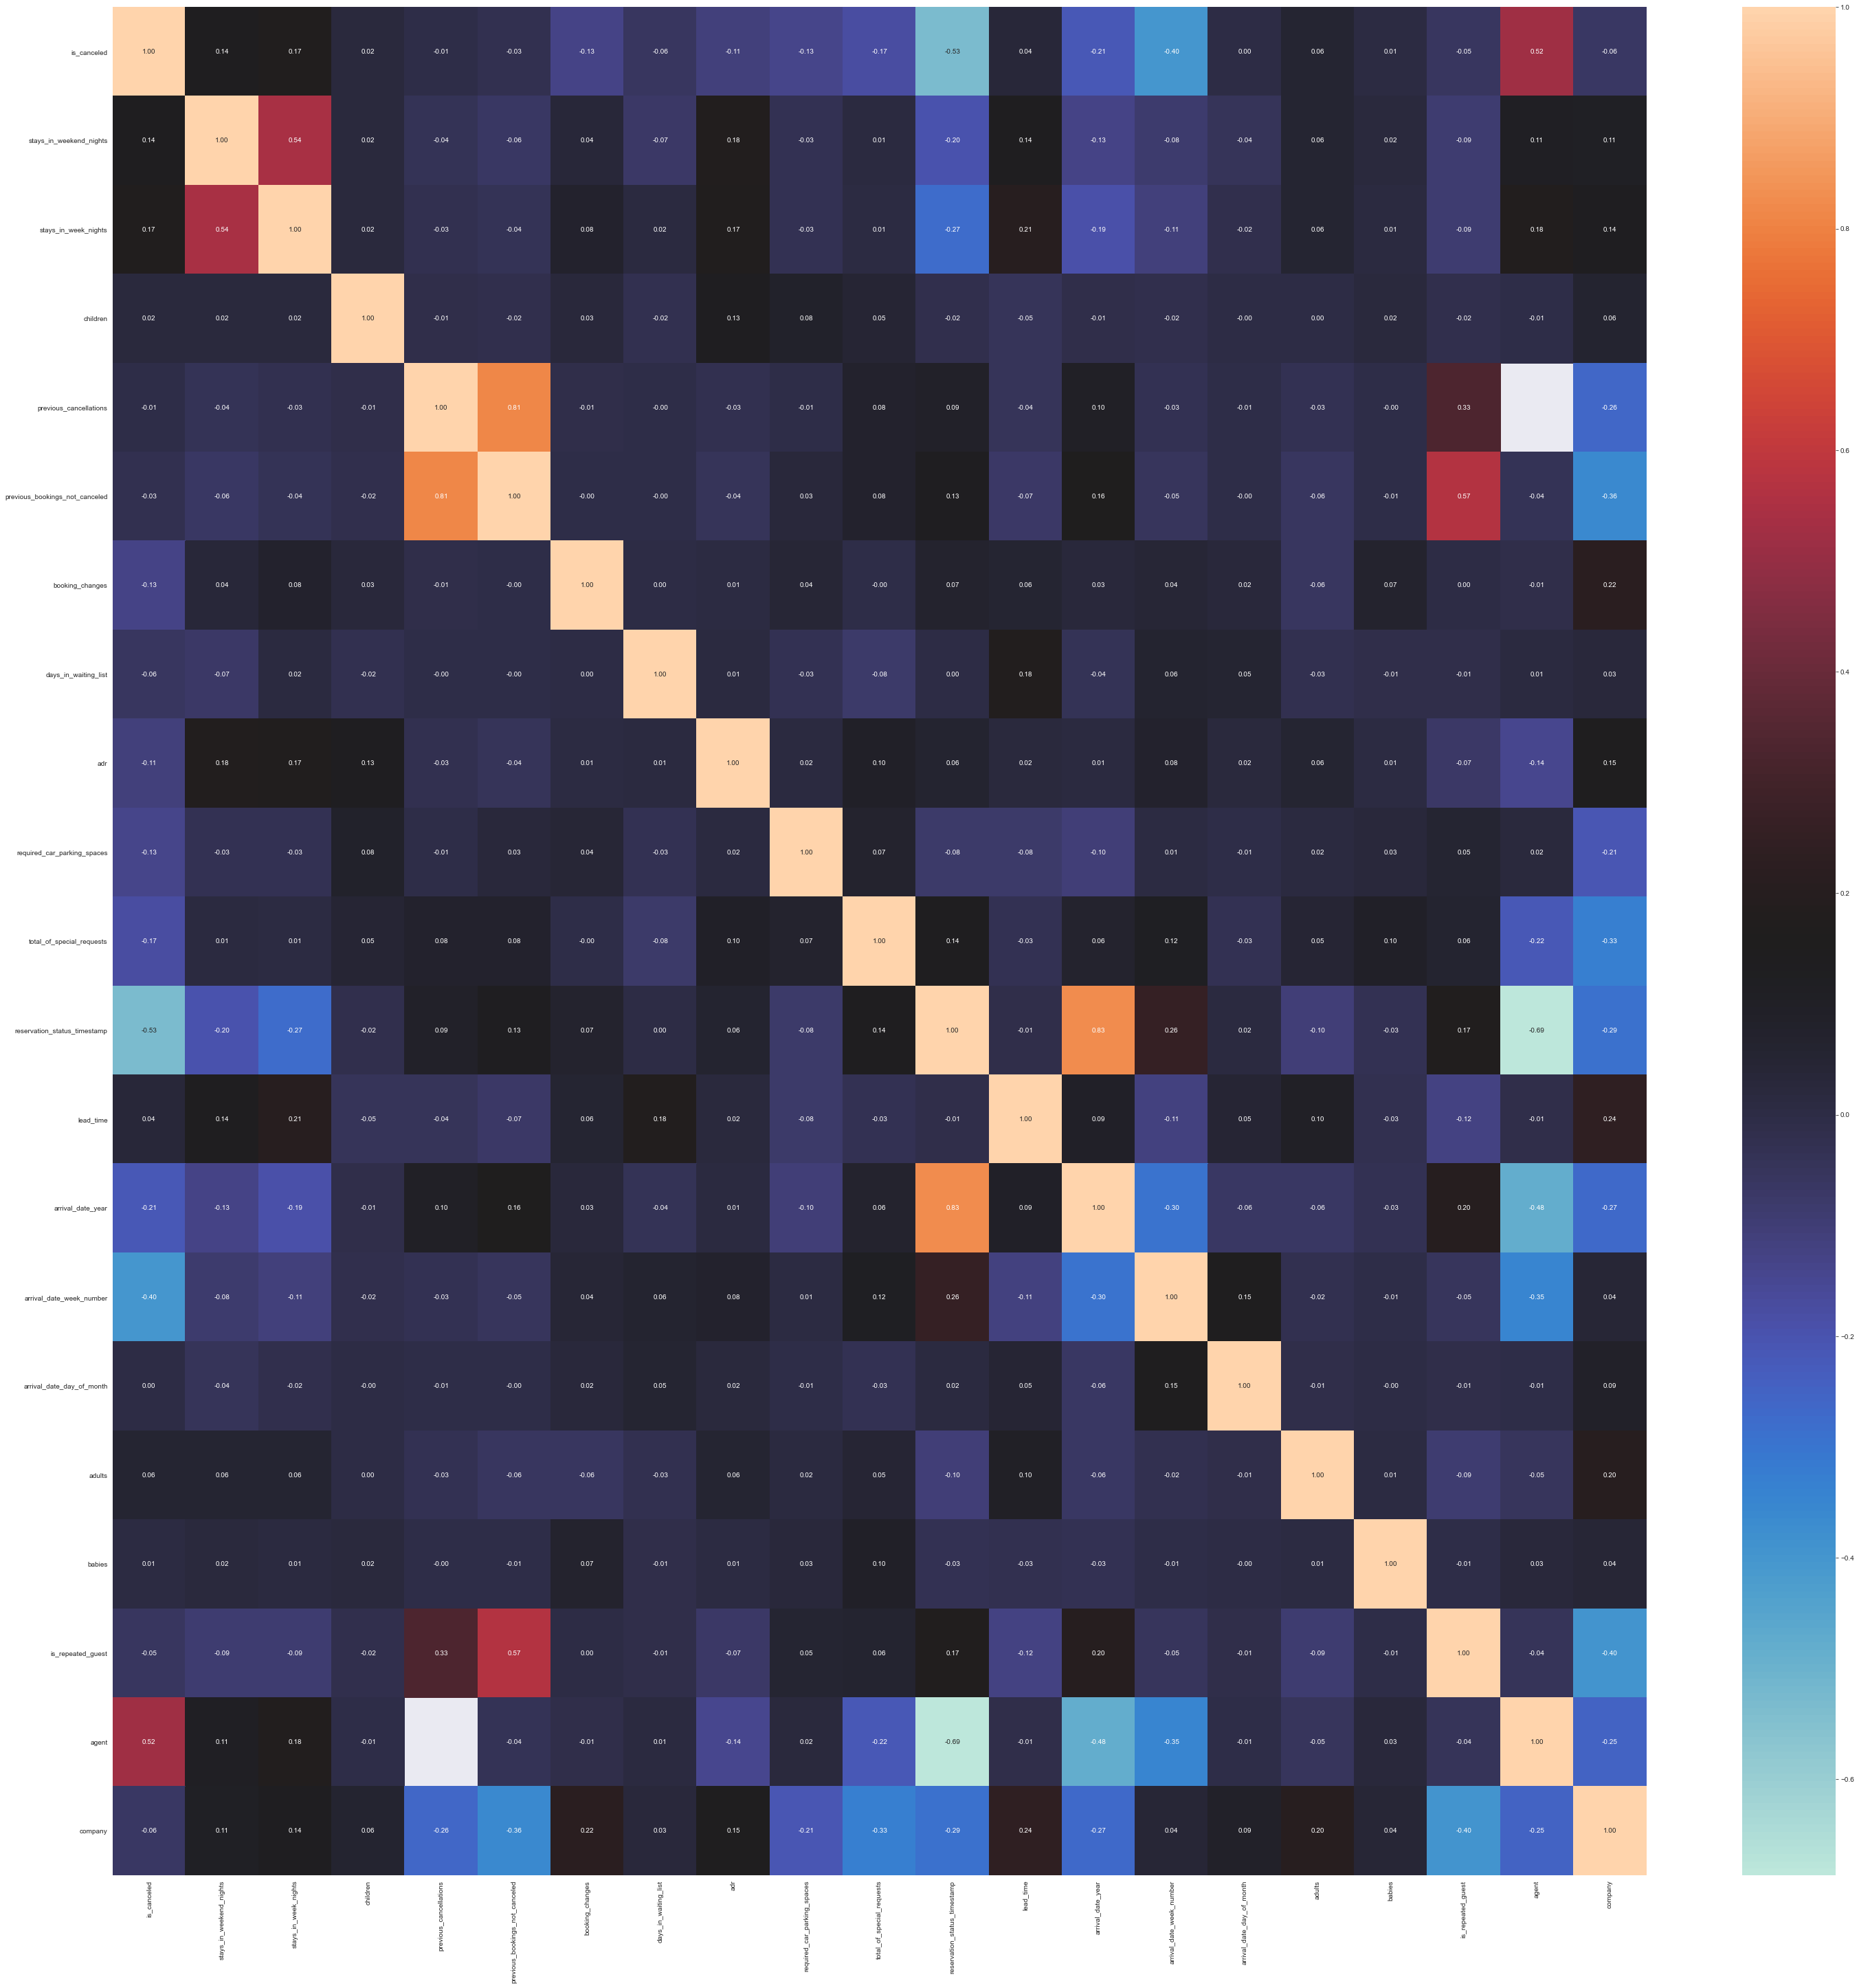

In [22]:
#selectedDataFrame = df_num.copy()
plt.subplots(figsize=(50,50))
sns.heatmap(df_num.corr(),annot=True, fmt = ".2f", cmap = "icefire")
#sns.heatmap(selectedDataFrame, annot=True)

#### Análise Bivariada em pares

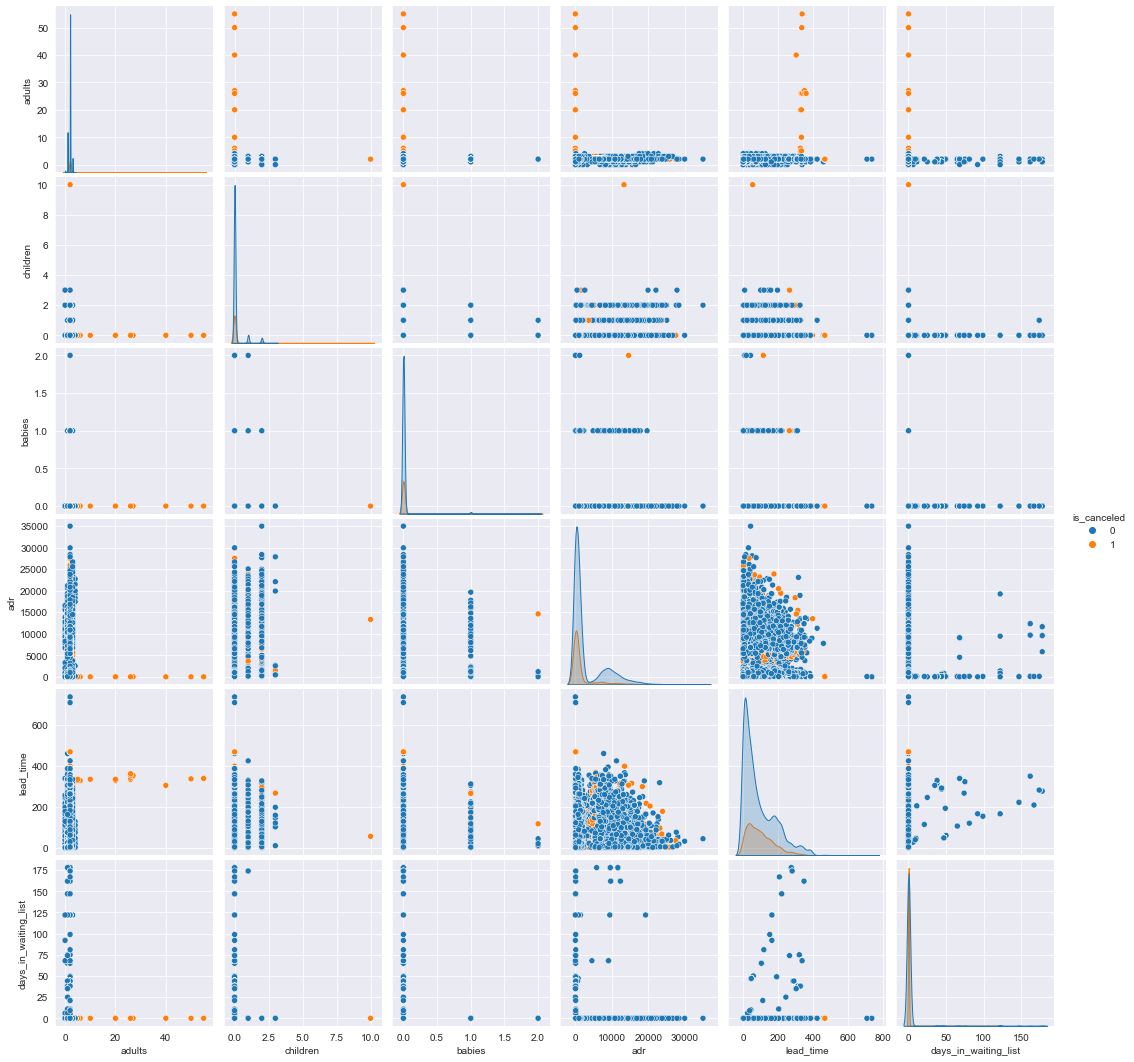

In [23]:
#Devido às limitações de hardware, vamos selecionar um sub-grupo de colunas para fazermos o gráfico de pairplot

#Criar um sub dataframe com um conjunto menor de colunas
selectedDataFrame = df_num[['adults','children','babies','adr','lead_time','days_in_waiting_list','is_canceled']].copy()


sns.pairplot(selectedDataFrame, hue = "is_canceled" )

In [24]:
## Criacao das variaveis dummies

dum_df = pd.get_dummies(df_cat2)

dataDum = df_num.join(dum_df)

dataDum.head(20)

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,children,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,...,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reservation_status_Canceled,reservation_status_Check-Out,reservation_status_No-Show
0,0,0,0,0,0,0,3,0,0,0,...,1,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,4,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,0,0,1,0,0,0,0,0,75,0,...,1,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,0,0,75,0,...,1,0,0,0,0,1,0,0,1,0
4,0,0,2,0,0,0,0,0,98,0,...,1,0,0,0,0,1,0,0,1,0
5,0,0,2,0,0,0,0,0,98,0,...,1,0,0,0,0,1,0,0,1,0
6,0,0,2,0,0,0,0,0,107,0,...,1,0,0,0,0,1,0,0,1,0
7,0,0,2,0,0,0,0,0,103,0,...,1,0,0,0,0,1,0,0,1,0
8,1,0,3,0,0,0,0,0,82,0,...,1,0,0,0,0,1,0,1,0,0
9,1,0,3,0,0,0,0,0,1055,0,...,1,0,0,0,0,1,0,1,0,0


#### Depois de limpar e organizar a base, iremos separar os Resorts (RH) dos Hotéis da Cidade (HC)
#### Para saber o número de visitantes, excluindo-se do cáluclo as reservas canceladas

In [ ]:
rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

### Agora iremos importar uma biblioteca gráfica para nos ajudar a descobrir a origem dos visitantes
#### Se não funcionar, instalar o módulo no terminal 'pip install chart-studio'

In [43]:
import plotly.express as px      

# Aqui atribuimos à variável 'country_data' a contagem total de visitantes
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"] == 0]["country"].value_counts())
#country_data.index.name = "indexamos e renomeamos o nome da coluna"
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
#Somamos o número de visitantes
total_guests = country_data["Number of Guests"].sum()
#Encontramos o percentual de visitantes de cada país dividido pelo total de visitantes. 
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
# indexamos a base de países
country_data["country"] = country_data.index

# Gráfico tipo Pizza
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Nacionalidade dos visitantes",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

### Aqui iremos compor a nacionalidade diretamente no mapa, aproveitando-se as variáveis anteriormente atribuídas

In [44]:
guest_map = px.choropleth(country_data,
                    locations=country_data.index,
                    color=country_data["Guests in %"], 
                    hover_name=country_data.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Nacionalidade dos Visitantes")
guest_map.show()

#### Aqui queremos saber o número de visitantes de cada mês nos hotéis da cidade e Resorts 

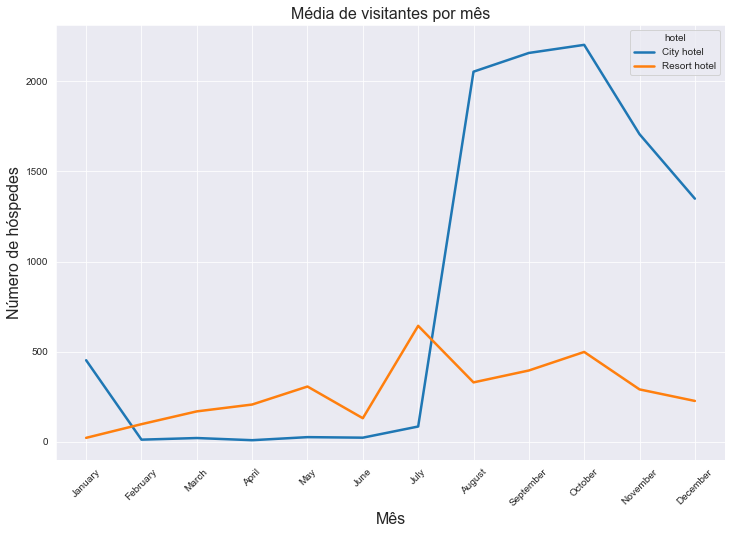

In [47]:
## Dividimos a contagem dos respectivos grupos (Resort X Cidade)
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

#### Criamos dois objetos e atribuímos a eles a lista de meses e valores de visitantes
resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})

### Concatenamos as duas listas na full_guest_data
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

### Ordenamos os meses
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

### Utilizamos a função do pandas 'pd.Categorical' para ordenar a lista de meses na base completa
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)



#sPlotagem do gráfico:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Média de visitantes por mês", fontsize=16)
plt.xlabel("Mês", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Número de hóspedes", fontsize=16)
plt.show()

### Segmentos de Mercado que utilizam o Booking, inclusive os cancelados

In [48]:
### Contagem de segmentos e valores

segments=full_data_cln["market_segment"].value_counts()

### Plotagem do gráfico
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Reservas de acordo com a segmentação de mercado",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

### Aqui vamos calcular o percentual de cancelamentos.

In [49]:
### Vamos calcular o total de cancelamentos
total_cancelations = full_data_cln["is_canceled"].sum()

### Separamos os cancelamentos em Resorts e Hotéis Urbanos
rh_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()

### Calculamos o percentual
rel_cancel = total_cancelations / full_data_cln.shape[0] * 100
rh_rel_cancel = rh_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0] * 100

### 
print(f"Total de reservas canceladas: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Cancelamentos de Resorts: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"Cancelamentos de Hotéis Urbanos: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total de reservas canceladas: 3,739 (22 %)
Cancelamentos de Resorts: 3,726 (53 %)
Cancelamentos de Hotéis Urbanos: 13 (0 %)
